# Cardano Treasury Tax Reduction Simulation

To analyze the impact of reducing Cardano’s treasury tax from 20% to 10%, we prepared a dataset for 2025–2035. This dataset is based on historical trends and assumptions from previous analyses and Cardano’s economic parameters. Currently, Cardano’s protocol diverts 20% of each epoch’s rewards to the treasury ([the Tau parameter](https://adapulse.io/the-cardano-treasury-tax/#:~:text=The%20Tau%20parameter%20is%20the,market%20valuation%20of%20%24695%2C886%2C944%20USD))​. As of late 2023, the treasury held roughly [1.5 billion ADA​](https://cexplorer.io/article/we-must-spend-responsibly-from-the-cardano-treasury#:~:text=The%20Cardano%20treasury%20holds%201,84%20billion%20ADA). With a tax reduction to 10%, the annual treasury inflow is expected to roughly halve (from about 300 million ADA in 2025 under 20% tax​ to ~150 million ADA under 10%).

At the same time, the primary treasury expenditure—Project Catalyst funding—has been around 200 million ADA per year (e.g. four funding rounds of 50M each in 2025)​. The dataset reflects these assumptions, showing the treasury’s projected balances if the tax is reduced to 10% and spending remains at current levels.

## Treasury Simulation Dataset (2025–2035)

The [CSV dataset](data/treasury_tax_reduction_data.csv) includes the following columns for each year: Year, Treasury Starting Balance (ADA), Expected Inflows (ADA), Expected Outflows (ADA), Net Change (ADA), and Treasury Ending Balance (ADA). All amounts are in ADA.

_Dataset Notes:_ 

* The Starting Balance for 2025 is about 1.7 billion ADA, which is in line with the ~1.52B ADA treasury at the end of 2023 plus additional growth in 2024​.

* Expected Inflows drop roughly 10% each year, reflecting the declining reserve rewards as Cardano’s reserve depletes (e.g. ~150M ADA in 2025 under a 10% tax, about half the ~300M with the 20% tax​, and gradually less in later years). 

* Expected Outflows are held at 200M ADA per year, assuming Project Catalyst continues to fund roughly 200M ADA annually​.

* The Net Change is simply Inflows minus Outflows, and the Ending Balance shows the treasury trend under these conditions (slowly decreasing over the decade as outflows exceed inflows).

## Monte Carlo Simulation Python Script

Below is a Python script that uses the above dataset to run a Monte Carlo simulation of Cardano’s treasury balance over the next 10 years (2025–2035). The simulation runs 10,000 iterations, introducing random variation to inflows and outflows each year to model uncertainty. It then plots possible future treasury balance trajectories, highlighting the median outcome and confidence intervals (e.g. 5th and 95th percentiles).

The script is commented on for clarity and references the data sources for assumptions by executing the next steps:

1. **Load the dataset:** Reads the CSV file into a pandas DataFrame.

2. **Setup simulation parameters:** Define the number of iterations and years, using the expected inflows/outflows from the dataset as the mean values for the simulation.

3. ** Monte Carlo simulation: ** Iterates 10,000 times, each time simulating year-by-year treasury balance changes. In each year, inflows and outflows are randomized around the expected values (using a normal distribution with a 10% standard deviation, truncated to ensure no negative values).

4. **Aggregate results:** The scripts collect all simulated treasury balances and compute the median and confidence intervals for each future year.

5. **Plot the results:** Uses Matplotlib to plot all simulated paths (in light transparency), the median trajectory (solid line), and shaded bands for the 90% confidence interval.

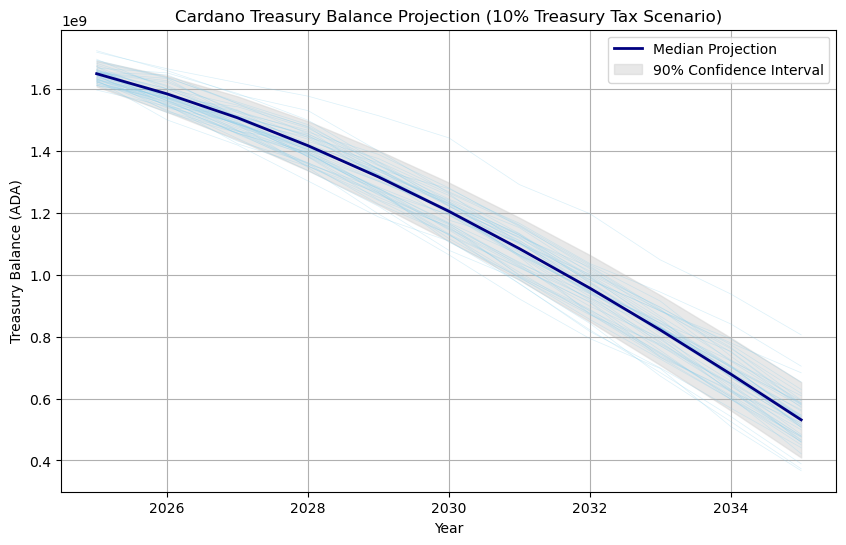

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Load the treasury dataset from the CSV file
# (Make sure the CSV file path is correct if running locally)
file_path = Path('data/treasury_tax_reduction_data.csv')
data = pd.read_csv(file_path)

# Extract data for simulation
years = data['Year'].values
expected_inflows = data['Expected Inflows (ADA)'].values
expected_outflows = data['Expected Outflows (ADA)'].values
initial_balance = data['Treasury Starting Balance (ADA)'].values[0]

# Simulation settings
num_iterations = 10000
num_years = len(years)

# Arrays to store simulation results
# We'll store the treasury balance for each year in each iteration
simulated_balances = np.zeros((num_iterations, num_years))

# Monte Carlo simulation
for i in range(num_iterations):
    balance = initial_balance  # start each simulation at the initial 2025 balance
    for j in range(num_years):
        # Randomize inflows and outflows for this year around expected values.
        # Assume a 10% standard deviation for unpredictability, and ensure values stay non-negative.
        inflow = np.random.normal(expected_inflows[j], 0.1 * expected_inflows[j])
        outflow = np.random.normal(expected_outflows[j], 0.1 * expected_outflows[j])
        if inflow < 0:
            inflow = 0
        if outflow < 0:
            outflow = 0
        # Calculate end-of-year balance for this iteration and year
        balance = balance + (inflow - outflow)
        simulated_balances[i, j] = balance

# Calculate statistics across all simulations
median_balances = np.median(simulated_balances, axis=0)
percentile5 = np.percentile(simulated_balances, 5, axis=0)    # 5th percentile (lower bound)
percentile95 = np.percentile(simulated_balances, 95, axis=0)  # 95th percentile (upper bound)

# Plot the simulation results
plt.figure(figsize=(10,6))
# Plot many simulation paths in thin, semi-transparent lines (to visualize variability)
for i in range(0, num_iterations, 200):  # plot a subset for performance (e.g., every 200th path)
    plt.plot(years, simulated_balances[i], color='skyblue', linewidth=0.5, alpha=0.3)
# Plot median trajectory
plt.plot(years, median_balances, color='navy', linewidth=2, label='Median Projection')
# Shade between 5th and 95th percentiles for 90% confidence interval
plt.fill_between(years, percentile5, percentile95, color='lightgray', alpha=0.5, label='90% Confidence Interval')
# Add labels and title
plt.title("Cardano Treasury Balance Projection (10% Treasury Tax Scenario)")
plt.xlabel("Year")
plt.ylabel("Treasury Balance (ADA)")
plt.legend()
plt.grid(True)
plt.show()

## Results Interpretation

In the plot above, the blue median line shows the most likely trajectory given the assumptions. The shaded region represents a 90% confidence interval – most simulations fall within this band.

In this 10% tax scenario, the treasury balance is likely to decline over time (since outflows of ~200M ADA/year outpace the halved inflows of ~150M ADA/year). By 2035, the median projected treasury balance is around 500–600 million ADA, down from ~1.7 billion in 2025, if these trends hold. This highlights the impact of reducing the treasury tax: **the treasury grows much more slowly and can even shrink if spending isn’t adjusted accordingly**.

## Sources

The assumptions for starting balance, inflow, and outflow are based on Cardano’s on-chain data and community reports. Cardano’s treasury held about 1.52–1.53 billion ADA in late 2023 ([CEXPLORER.IO](https://cexplorer.io/article/we-must-spend-responsibly-from-the-cardano-treasury#:~:text=The%20Cardano%20treasury%20holds%201,84%20billion%20ADA), [ADAPULSE.IO](https://adapulse.io/the-cardano-treasury-tax/#:~:text=The%20Tau%20parameter%20is%20the,market%20valuation%20of%20%24695%2C886%2C944%20USD)).

With the treasury tax at 20%, roughly 4.7M ADA per epoch (every 5 days) was added to the treasury, projecting to ~300M ADA per year in 2025​ ([CEXPLORER.IO](https://cexplorer.io/article/we-must-spend-responsibly-from-the-cardano-treasury#:~:text=Each%20epoch%2C%20Cardano%20cashes%20in,are%20deposited%20into%20the%20treasury))
​
The proposed 10% tax would halve that rate. On the spending side, Project Catalyst has been allocating ~50M ADA per round, with 3–4 rounds per year (≈200M ADA/year) ([CEXPLORER.IO](https://cexplorer.io/article/we-must-spend-responsibly-from-the-cardano-treasury#:~:text=The%20sole%20expenditure%20from%20the,from%20the%20treasury%20in%202025)). These figures were used to model the scenario in our simulation.